##### Copyright 2025 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Gemini 2.0 - Grounding using Search as a tool

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Search_Grounding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

In this notebook you will learn how to use the new Google Search tool available in [Gemini 2.0](https://ai.google.dev/gemini-api/docs/models/gemini-v2), using both the unary API and the Multimodal Live API. Check out the docs to learn more about using [Search as a tool](https://ai.google.dev/gemini-api/docs/models/gemini-v2#search-tool).

Note that the previous version of this guide using Gemini models priori to 2.0 and the legacy SDK can still be found [here](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/quickstarts/Search_Grounding.ipynb).

## Set up the SDK

This guide uses the [`google-genai`](https://pypi.org/project/google-genai) Python SDK to connect to the Gemini 2.0 models.

### Install SDK

The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides programmatic access to Gemini 2 (and previous models) using both the [Google AI for Developers](https://ai.google.dev/gemini-api/docs/models/gemini-v2) and [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview) APIs. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

More details about this new SDK on the [documentation](https://googleapis.github.io/python-genai/) or in the [Getting started](./Get_started.ipynb) notebook.

In [2]:
%pip install -q -U "google-genai>=1.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.7/159.7 kB 2.6 MB/s eta 0:00:00


### Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/gemini-api-cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [3]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

### Select model and initialize SDK client

The client will pick up your API key from the environment variable.
To use the live API you need to set the client version to `v1alpha` and use the Gemini 2.0 model.

Now select the model you want to use in this guide, either by selecting one in the list or writing it down. Keep in mind that some models, like the 2.5 ones are thinking models and thus take slightly more time to respond (cf. [thinking notebook](./Get_started_thinking.ipynb) for more details and in particular learn how to switch the thiking off).

In [4]:
from google import genai

client = genai.Client() # the API is automatically loaded from the environement variable

MODEL_ID = "gemini-2.5-flash-preview-04-17" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-flash-preview-04-17","gemini-2.5-pro-exp-03-25"] {"allow-input":true, isTemplate: true}

## Use Google Search
Search grounding is particularly useful for queries that require current information or external knowledge. Using Google Search, Gemini can access nearly real-time information and better responses.

In [10]:
from IPython.display import HTML, Markdown

response = client.models.generate_content(
    model=MODEL_ID,
    contents='What was the latest Indian Premier League match and who won?',
    config={"tools": [{"google_search": {}}]},
)

# print the response
display(Markdown(f"Response:\n {response.text}"))
# print the search details
print(f"Search Query: {response.candidates[0].grounding_metadata.web_search_queries}")
# urls used for grounding
print(f"Search Pages: {', '.join([site.web.title for site in response.candidates[0].grounding_metadata.grounding_chunks])}")

display(HTML(response.candidates[0].grounding_metadata.search_entry_point.rendered_content))

Response:
 The latest Indian Premier League (IPL) match results show several recent games.

According to the search results, here are the most recent matches and their winners:

*   **April 18, 2025:** Mumbai Indians defeated Sunrisers Hyderabad by four wickets in Mumbai.
*   **April 16, 2025:** Delhi Capitals won against Rajasthan Royals in a Super Over after the match was tied in Delhi.
*   **April 15, 2025:** Punjab Kings won by 16 runs against Kolkata Knight Riders in Mullanpur.
*   **April 14, 2025:** Chennai Super Kings won by 5 wickets against Lucknow Super Giants in Lucknow.

Based on the dates, the match on April 18, 2025, between Mumbai Indians and Sunrisers Hyderabad appears to be the most recent one listed, with Mumbai Indians winning.

Search Query: ['latest IPL match result', 'last IPL match and winner']
Search Pages: indiatimes.com, thehindu.com, thehindu.com, indiatimes.com, iplt20.com


The information provided may be outdated, as it is based on a knowledge cutoff. For the most current and authoritative details, please refer to the official [Model documentation](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro-exp-03-25), which includes the latest knowledge cutoff date.

You can see that running the same prompt without search grounding gives you outdated information:

In [12]:
from IPython.display import Markdown

response = client.models.generate_content(
    model=MODEL_ID,
    contents='What was the latest Indian Premier League match and who won?',
)

# print the response
display(Markdown(response.text))

The latest Indian Premier League (IPL) match played was the **Final of the IPL 2024 season**.

It was played between:

*   **Kolkata Knight Riders (KKR)**
*   **Sunrisers Hyderabad (SRH)**

**Kolkata Knight Riders (KKR) won** that match, securing the IPL 2024 championship title.

The IPL 2024 season has now concluded.

## Use search in chat

Start by defining a helper function that you will use to display each part of the returned response.

In [8]:
# @title Define some helpers (run this cell)
import json

from IPython.display import display, HTML, Markdown


def show_json(obj):
  print(json.dumps(obj.model_dump(exclude_none=True), indent=2))

def show_parts(r):
  parts = r.candidates[0].content.parts
  if parts is None:
    finish_reason = r.candidates[0].finish_reason
    print(f'{finish_reason=}')
    return
  for part in r.candidates[0].content.parts:
    if part.text:
      display(Markdown(part.text))
    elif part.executable_code:
      display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    else:
      show_json(part)

  grounding_metadata = r.candidates[0].grounding_metadata
  if grounding_metadata and grounding_metadata.search_entry_point:
    display(HTML(grounding_metadata.search_entry_point.rendered_content))


First try a query that needs realtime information, so you can see how the model performs _without_ Google Search.

In [13]:
chat = client.chats.create(model=MODEL_ID)

response = chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')

show_parts(response)

The most recent games between Australia and Chinese Taipei in major international competition were in **football (soccer)**.

They played two matches in November 2023 as part of the FIFA World Cup 2026 and AFC Asian Cup 2027 Joint Qualification.

**Australia won both matches:**

*   **November 16, 2023:** Australia 7 - 0 Chinese Taipei
*   **November 21, 2023:** Chinese Taipei 0 - 1 Australia

So, **Australia won the most recent games** between the two sides.

Now set up a new chat session that uses the `google_search` tool.  The `show_parts` helper will display the text output as well as any Google Search queries used in the results.

In [14]:
search_tool = {'google_search': {}}

soccer_chat = client.chats.create(
    model=MODEL_ID,
    config={'tools': [search_tool]}
)

response = soccer_chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')

show_parts(response)

Based on the search results, it appears the most recent games between Australia and Chinese Taipei have been in women's football (soccer).

According to the provided information, the two most recent matches were:

*   **December 7, 2024:** Australia Women vs Chinese Taipei Women. Australia won with a score of 6-0 [4, 9, 10].
*   **December 4, 2024:** Australia Women vs Chinese Taipei Women. Australia won with a score of 3-1 [4, 5, 10].

Therefore, Australia won the two most recent games against Chinese Taipei in women's football.

As you are using a `chat` session, you can ask the model follow-up questions too.

In [15]:
response = soccer_chat.send_message('Who scored the goals?')

show_parts(response)

Based on the search results, here are the goalscorers for the two most recent matches between Australia Women and Chinese Taipei Women in December 2024:

**December 7, 2024: Australia 6-0 Chinese Taipei** [5, 7, 10, 11]

*   Leah Davidson
*   Tameka Yallop
*   Emily Gielnik
*   Michelle Heyman
*   Natasha Prior
*   Sharn Freier

**December 4, 2024: Australia 3-1 Chinese Taipei** [3, 4, 6, 8, 9, 12]

*   **Australia:**
    *   Natasha Prior
    *   Sharn Freier
    *   Bryleeh Henry
*   **Chinese Taipei:**
    *   Chen Jin-Wen

## Plot search results


In this example you can see how to use the Google Search tool with code generation in order to plot results.

In [16]:
movie_chat = client.chats.create(
    model=MODEL_ID,
    config={'tools': [search_tool]}
)

response = movie_chat.send_message('Generate some Python code to plot the runtimes of the last 10 Denis Villeneuve movies.')

show_parts(response)

Okay, here is Python code using the `matplotlib` library to plot the runtimes of the last 10 feature films directed by Denis Villeneuve.



```python
import matplotlib.pyplot as plt

# Data for the last 10 Denis Villeneuve feature films (ordered from oldest to newest)
# Source for movies and runtimes: various sources including IMDb, Screen Rant, Collider
movies = [
    "Maelstrom (2000)",
    "Polytechnique (2009)",
    "Incendies (2010)",
    "Prisoners (2013)",
    "Enemy (2013)",
    "Sicario (2015)",
    "Arrival (2016)",
    "Blade Runner 2049 (2017)",
    "Dune: Part One (2021)",
    "Dune: Part Two (2024)"
]

runtimes_minutes = [
    87,  # Maelstrom
    77,  # Polytechnique
    131, # Incendies
    153, # Prisoners
    91,  # Enemy
    121, # Sicario
    116, # Arrival
    163, # Blade Runner 2049
    155, # Dune: Part One
    163  # Dune: Part Two
]

# Create the bar plot
plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
plt.bar(movies, runtimes_minutes, color='skyblue')

# Add labels and title
plt.xlabel("Movie")
plt.ylabel("Runtime (minutes)")
plt.title("Runtimes of the Last 10 Denis Villeneuve Feature Films")
plt.xticks(rotation=45, ha='right') # Rotate movie names for better visibility
plt.tight_layout() # Adjust layout to prevent labels overlapping

# Show the plot
plt.show()
```



**Explanation:**

1.  **Import matplotlib:** Imports the necessary plotting library.
2.  **Movie Titles and Runtimes:** Two lists are created, one for the movie titles and the other for their corresponding runtimes in minutes. The movies are listed in chronological order from oldest to most recent of the last 10.
3.  **Create Bar Plot:** `plt.bar()` is used to generate the bar chart. The `movies` list provides the labels for the x-axis, and `runtimes_minutes` provides the height of each bar.
4.  **Labels and Title:** `plt.xlabel()`, `plt.ylabel()`, and `plt.title()` are used to add descriptions to the axes and the plot itself.
5.  **Rotate X-axis Labels:** `plt.xticks(rotation=45, ha='right')` rotates the movie titles on the x-axis by 45 degrees to prevent them from overlapping.
6.  **Tight Layout:** `plt.tight_layout()` adjusts the plot parameters for a tight layout.
7.  **Show Plot:** `plt.show()` displays the generated plot.

This code will generate a bar chart visually representing the runtime of each of the specified Denis Villeneuve movies.

First review the supplied code to make sure it does what you expect, then copy it here to try out the chart.

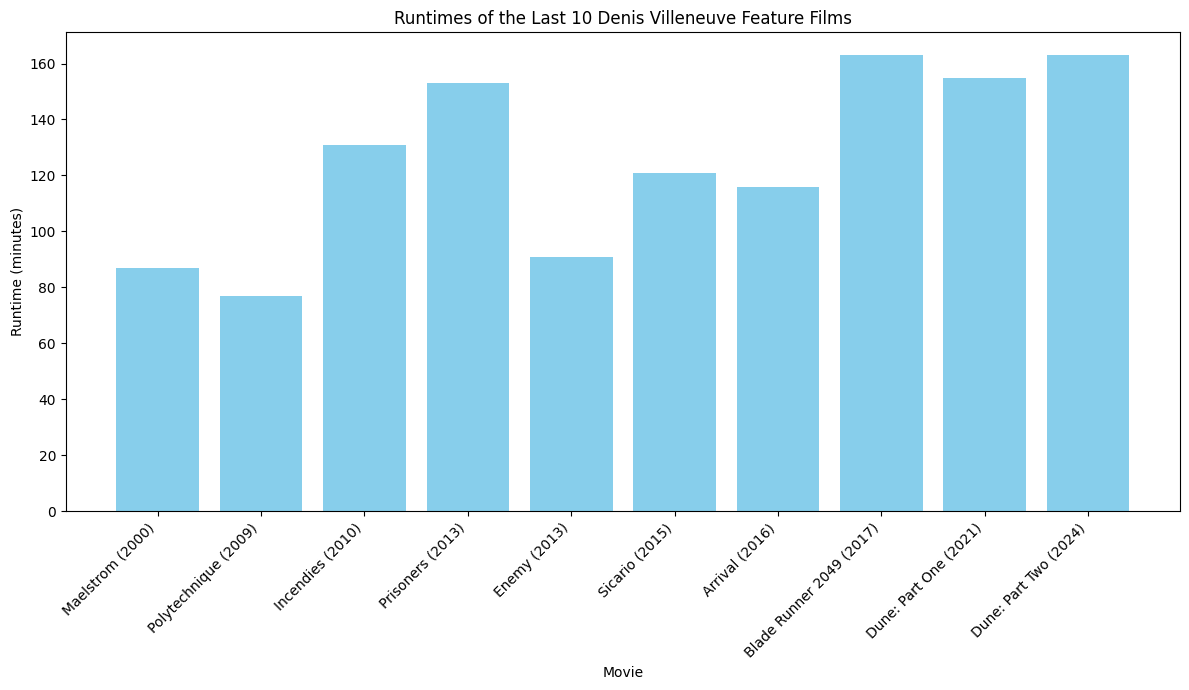

In [18]:
import re

matchFound = re.search(r"python\n(.*?)```", response.text, re.DOTALL)

if matchFound:
  code = matchFound.group(1)
  exec(code)

One feature of using a chat conversation to do this is that you can now ask the model to make changes.

In [19]:
response = movie_chat.send_message('Looks great! Can you give the chart a dark theme instead?')

show_parts(response)

Okay, we can easily apply a dark theme to the chart using Matplotlib's built-in styles. The `dark_background` style is a good option for this.

Here's the modified Python code:



```python
import matplotlib.pyplot as plt

# Data for the last 10 Denis Villeneuve feature films (ordered from oldest to newest)
# Source for movies and runtimes: various sources including IMDb, Screen Rant, Collider
movies = [
    "Maelstrom (2000)",
    "Polytechnique (2009)",
    "Incendies (2010)",
    "Prisoners (2013)",
    "Enemy (2013)",
    "Sicario (2015)",
    "Arrival (2016)",
    "Blade Runner 2049 (2017)",
    "Dune: Part One (2021)",
    "Dune: Part Two (2024)"
]

runtimes_minutes = [
    87,  # Maelstrom
    77,  # Polytechnique
    131, # Incendies
    153, # Prisoners
    91,  # Enemy
    121, # Sicario
    116, # Arrival
    163, # Blade Runner 2049
    155, # Dune: Part One
    163  # Dune: Part Two
]

# Apply a dark theme style
plt.style.use('dark_background')

# Create the bar plot
plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
plt.bar(movies, runtimes_minutes, color='skyblue') # 'skyblue' still works well on a dark background

# Add labels and title
plt.xlabel("Movie")
plt.ylabel("Runtime (minutes)")
plt.title("Runtimes of the Last 10 Denis Villeneuve Feature Films")
plt.xticks(rotation=45, ha='right') # Rotate movie names for better visibility
plt.tight_layout() # Adjust layout to prevent labels overlapping

# Show the plot
plt.show()
```



**Key Change:**

We added the line `plt.style.use('dark_background')` before creating the plot. This tells Matplotlib to use its built-in `dark_background` style, which changes the background, text, and axis colors to be suitable for a dark theme.

The bar color 'skyblue' still provides good contrast against the dark background. You could experiment with other colors if you like, but 'skyblue' should look fine.

Again, always be sure to review code generated by the model before running it.

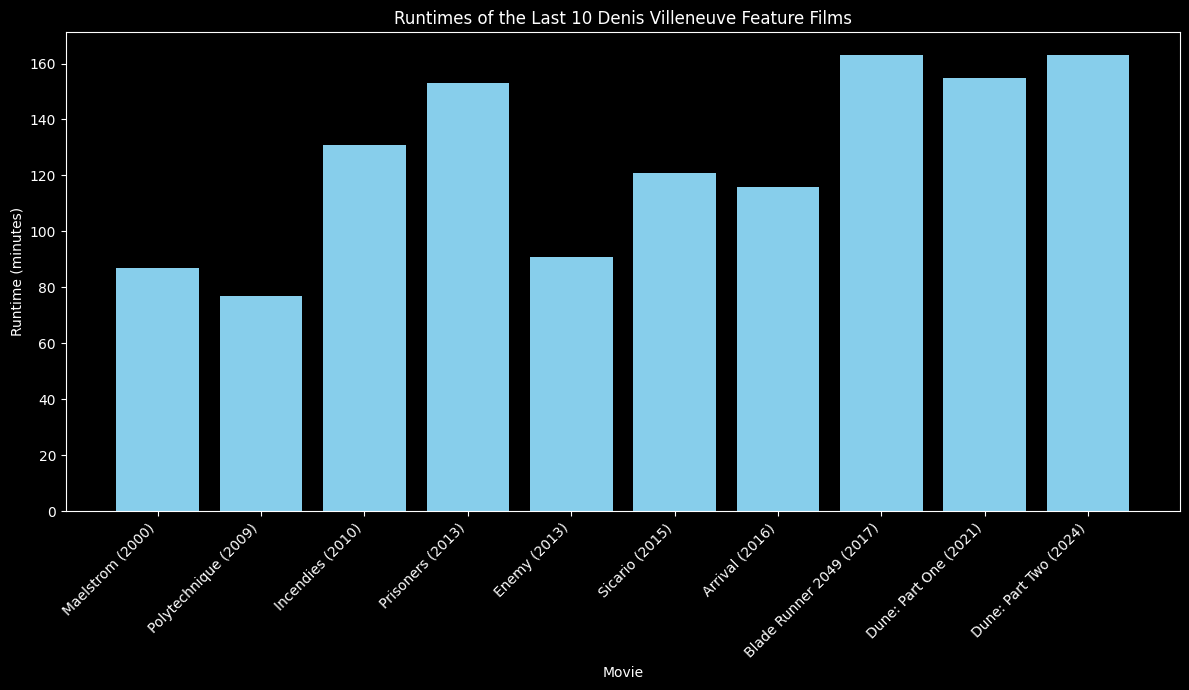

In [21]:
import re

matchFound = re.search(r"python\n(.*?)```", response.text, re.DOTALL)

if matchFound:
  code = matchFound.group(1)
  exec(code)

## Use search in the Multimodal Live API

The Search tool can be used in a live streaming context to have the model formulate grounded responses during the conversation.

In [ ]:
# Live API only works with v1alpha API and with the gemini-2.0-flash-exp model at the moment

client = genai.Client(http_options={'api_version': 'v1alpha'})

LIVE_MODEL = "gemini-2.0-flash-exp"

### Define some helpers

To use the bi-directional streaming API in Colab, you will buffer the audio stream. Define a `play_response` helper function to do the buffering, and once the audio for the current turn has completed, display an IPython audio widget.

As each of the following examples only use a single prompt, also define a `run` helper to wrap the setup and prompt execution steps into a single function call. This helper takes a `config` argument that will be added to the `generation_config`, so that you can toggle the Search tool between examples.

In [ ]:
# @title Helper functions for the Live API (run this cell)

import asyncio
import io
import json
import re
import time
import wave

import numpy as np
from IPython.display import Audio, display


DEFAULT_OUTPUT_RATE = 24000
BASE_MODEL_CONFIG = {
    # Here you can change the model's output mode between either audio or text.
    # While this code expects an audio stream, text should work, but the stream
    # may interleave with the `Buffering....` text.
    'response_modalities': ['AUDIO']
}

async def play_response(stream):
  """Buffer audio output and display a widget. Returns the streamed responses."""
  turn_buf = io.BytesIO()
  sample_rate = DEFAULT_OUTPUT_RATE

  all_responses = []

  print('Buffering', end='')
  async for msg in stream.receive():
    all_responses.append(msg)

    if text:=msg.text:
      print(text)
    if audio_data := msg.data:
      turn_buf.write(audio_data)
      if m := re.search(
          'rate=(?P<rate>\d+)',
          msg.server_content.model_turn.parts[0].inline_data.mime_type
      ):
            sample_rate = int(m.group('rate'))

    elif tool_call := msg.tool_call:
      # Handle tool-call requests. Here is where you would implement
      # custom tool code, but for this example, all tools respond 'ok'.
      for fc in tool_call.function_calls:
        print('Tool call', end='')
        tool_response = genai.types.LiveClientToolResponse(
            function_responses=[genai.types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': 'ok'},
            )]
        )
        await stream.send(input=tool_response)

    print('.', end='')

  print()

  # Play the audio
  if turn_buf.tell():
    audio = np.frombuffer(turn_buf.getvalue(), dtype=np.int16)
    display(Audio(audio, autoplay=True, rate=sample_rate))
  else:
    print('No audio :(')
    print(f'  {len(all_responses)=}')

  return all_responses


async def run(query, config=None):
  # Add any tools or other generation config.
  config = BASE_MODEL_CONFIG | (config or {})

  # Establish a live session. While this context manager is active, the
  # conversation will continue.
  async with client.aio.live.connect(model=LIVE_MODEL_ID, config=config) as strm:

    # Send the prompt.
    await strm.send(input=query, end_of_turn=True)
    # Handle the model response.
    responses = await play_response(strm)

    return responses

### Stream with the Search tool

First, execute a query _without_ the Search tool to observe the model's response to a time-sensitive query.

Note that the Multimodal Live API is a 2-way streaming API, but to simplify running in a notebook, each audio response is buffered and played once it has been fully streamed, so you will need to wait a few seconds before the response starts to play.

In [ ]:
await run('Who won the skateboarding gold medals in the 2024 olympics?');

Buffering.......................................


Now re-run with the Search tool enabled.

In [ ]:
responses = await run('Who won the skateboarding gold medals in the 2024 olympics?', {'tools': [search_tool]})

Buffering.............................................................................


If you wish to see the full output that was returned, you can enable `show_output` here and run this cell. It includes the complete audio binary data, so it is off by default.

In [ ]:
show_output = False

if show_output:
  for msg in responses:
    print(msg.model_dump(exclude_none=True))

### Search with custom tools

In the Multimodal Live API, the Search tool can be used in conjunction with other tools, including function calls that you provide to the model.

In this example, you define a function `set_climate` that takes 2 parameters, `mode` (`hot`, `cold`, etc) and `strength` (0-10), and ask the model to set the climate control based on the live weather in the location you specify.

In [ ]:
set_climate_tool = {'function_declarations': [{
    'name': 'set_climate',
    'description': 'Switches the local climate control equipment to the specified parameters.',
    'parameters': {
      'type': 'OBJECT',
      'properties': {
        # Define the "mode" argument.
        'mode': {
            'type': 'STRING',
            'enum': [
              # Define the possible values for "mode".
              "hot",
              "cold",
              "fan",
              "off",
            ],
            'description': 'Mode for the climate unit - whether to heat, cool or just blow air.',
        },
        # Define the "strength" argument.
        'strength': {
            'type': 'INTEGER',
            'description': 'Intensity of the climate to apply, 0-10 (0 is off, 10 is MAX).',
        },
      },
    },
  },
]}

search_tool = {'google_search': {}}

tools = {'tools': [search_tool, set_climate_tool]}

responses = await run("Look up the weather in Paris and set my climate control appropriately.", tools)

Buffering..............................................................................................................


Now inspect the `tool_call` response(s) you received during the conversation.

In [ ]:
for r in responses:
  if tool := r.tool_call:
    for fn in tool.function_calls:
      args = ', '.join(f'{k}={v}' for k, v in fn.args.items())
      print(f'{fn.name}({args})  # id={fn.id}')

## Next steps

<a name="next_steps"></a>

* For more demos showcasing multi-tool use in the Multimodal Live API, check out the [Plotting and Mapping cookbook](../examples/LiveAPI_plotting_and_mapping.ipynb).
* To get started with the Live API with the Python SDK, check out the [starter guide](./Get_started_LiveAPI.ipynb).
* To learn more about tool use in the Live API, check out the [Live API Tool Use cookbook](./Get_started_LiveAPI_tools.ipynb).

Also check the other Gemini advanced capabilities (like [spatial understanding](../quickstarts/Spatial_understanding.ipynb)) that you can find in the [Gemini Cookbook](https://github.com/google-gemini/cookbook/tree/main/gemini-2/).